## Encoding strategies
* This file implements different encoding strategies like direct translation

In [1]:
import os, sys
import numpy as np
import json
import random
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

## Preliminary

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset

In [3]:
class BinaryDataset(Dataset):
    def __init__(self, filepath):
        def construct_binary_dataset(filepath):
            with open(filepath, 'r') as f:
                aptamer_data = json.load(f)
            ds = []
            for aptamer in aptamer_data:
                peptides = aptamer_data[aptamer]
                for peptide in peptides:
                    ds.append((aptamer, peptide, 1))
                    ds.append((get_x(), get_y(), 0))
            ds = list(set(ds)) #removed duplicates, random order
            return ds

        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y

        self.binary_ds=construct_binary_dataset(filepath)

    def __len__(self):
        return len(self.binary_ds)

    def __getitem__(self,idx):
        return(self.binary_ds[idx])

In [4]:
class GeneratedDataset(Dataset):
    def __init__(self, n):
        def construct_generated_dataset(k):
            S_new = []
            for _, i in enumerate(tqdm.tqdm(range(k))):
                pair = (get_x(), get_y())
                S_new.append(pair)
            np.random.shuffle(S_new)
            return S_new
        
        # Sample x from P_X (assume apatamers follow uniform)
        def get_x():
            x_idx = np.random.randint(0, 4, 40)
            x = ""
            for i in x_idx:
                x += na_list[i]
            return x

        # Sample y from P_y (assume peptides follow NNK)
        def get_y():
            y_idx = np.random.choice(20, 7, p=pvals)
            y = "M"
            for i in y_idx:
                y += aa_list[i]
            return y
        self.gen_ds = construct_generated_dataset(n)
    def __len__(self):
        return len(self.gen_ds)
    
    def __getitem__(self, idx):
        return (self.gen_ds[idx])

In [5]:
binary_ds=BinaryDataset(filepath="../data/aptamer_dataset.json")
n = len(binary_ds)
m = int(0.8*n) #length of train
binary_train = binary_ds[:m]
binary_val = binary_ds[m:]

In [6]:
# For the CDF functions, we need to generate a dataset of new examples
S_new = GeneratedDataset(10*m)

100%|██████████| 9460940/9460940 [14:33<00:00, 10825.66it/s]


## NN Model

In [8]:
class TranslateNet(nn.Module):
    def __init__(self):
        super(TranslateNet, self).__init__()
        self.name = "TranslateNet"
        
        self.cnn_apt_1 = nn.Conv1d(40, 25, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(25, 15, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(15, 10, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(10, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(8, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 5, 1, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(15, 5)
        self.fc2 = nn.Linear(5, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(1, 2, 0)
        pep = pep.permute(1, 2, 0)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [9]:
class TranslateComplexNet(nn.Module):
    def __init__(self):
        super(TranslateComplexNet, self).__init__()
        self.name = "TranslateComplexNet"
        
        self.cnn_apt_1 = nn.Conv1d(40, 100, 2, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(100, 250, 2, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(250, 500, 2, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(500, 250, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(8, 50, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 2, padding=2)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 2, padding=2)
        self.cnn_pep_4 = nn.Conv1d(200, 150, 2, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     self.cnn_pep_3, self.maxpool, self.relu,
                                     self.cnn_pep_4, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(550, 100)
        self.fc2 = nn.Linear(100, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(1, 2, 0)
        pep = pep.permute(1, 2, 0)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [25]:
class TranslateBatchNet(nn.Module):
    def __init__(self):
        super(TranslateBatchNet, self).__init__()
        self.name = "TranslateBatchNet"
        
        self.cnn_apt_1 = nn.Conv1d(1, 20, 3) 
        self.cnn_apt_2 = nn.Conv1d(20, 30, 3, padding=2) 
        self.cnn_apt_3 = nn.Conv1d(30, 20, 3, padding=2) 
        self.cnn_apt_4 = nn.Conv1d(20, 5, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(1, 15, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(15, 30, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(30, 10, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(10, 5, 2, padding=2)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu,
                                     self.cnn_pep_3, self.maxpool, self.relu,
                                     self.cnn_pep_4, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(25, 10)
        self.fc2 = nn.Linear(10, 1)
    
    def forward(self, apt, pep):
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [7]:
def weights_init(m):
    if isinstance(m, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

## Helper methods

In [10]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def translate(sequence, seq_type='peptide', single_alphabet=False):
    if single_alphabet:
        apt = sequence[0]
        pep = sequence[1]
        
        encoding = np.zeros(len(apt) + len(pep))
        
        # Encode the aptamer first
        for i in range(len(apt)):
            char = apt[i]
            idx = na_list.index(char)
            encoding[i] = idx
            
        # Encode the peptide second
        for i in range(len(pep)):
            char = pep[i]
            idx = aa_list.index(char)
            encoding[i+len(apt)] = idx
        return encoding     
    else:
        if seq_type == 'peptide':
            letters = aa_list
        else:
            letters = na_list
        
        encoding = np.zeros(len(sequence))
        for i in range(len(sequence)):
            char = sequence[i]
            idx = letters.index(char)
            encoding[i] = idx
        return encoding

# Convert a pair to one-hot tensor
def convert(apt, pep, label, single_alphabet=False): 
    if single_alphabet:
        pair = translate([apt, pep], single_alphabet=True)
        pair = torch.FloatTensor(np.reshape(pair, (-1, pair.shape[0], pair.shape[1]))).to(device)
        label = torch.FloatTensor([[label]]).to(device)
        return pair, label
    else:
        apt = translate(apt, seq_type='aptamer') #(40, )
        pep = translate(pep, seq_type='peptide') #(8, )
        apt = torch.FloatTensor(np.reshape(apt, (-1, 1, apt.shape[0]))).to(device) #(1, 1, 40)
        pep = torch.FloatTensor(np.reshape(pep, (-1, 1, pep.shape[0]))).to(device) #(1, 1, 8)
        label = torch.FloatTensor([[label]]).to(device)
        return apt, pep, label

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y, p, single_alphabet=False):
    if single_alphabet:
        p.requires_grad=True
        p = p.to(device)
        out = model(p)
        return out
    else:
        x.requires_grad=True
        y.requires_grad=True
        x = x.to(device)
        y = y.to(device)
        out = model(x, y)
        return out

## Plotting functions
def plot_loss(iters, train_losses, val_losses, model_name, model_id):
    plt.title("Training Loss Curve")
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/loss.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_accuracy(iters, train_acc, val_acc, model_name, model_id):
    plt.title("Training Accuracy Curve")
    plt.plot(train_acc, label="Train")
    plt.plot(val_acc, label="Validation")
    plt.xlabel("%d Iterations" %iters)
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.savefig('plots/binary/%s/%s/accuracy.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    
    sns.distplot(train_gen_scores , color="skyblue", label='Generated Train Samples', ax=ax)
    sns.distplot(val_gen_scores, color='dodgerblue', label='Generated Validation Samples')
    sns.distplot(train_scores , color="lightcoral", label='Dataset Train Samples', ax=ax)
    sns.distplot(val_scores, color='red', label='Dataset Validation Samples', ax=ax)
    
    ax.set_title("Categorizing the output scores of the model")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/binary/%s/%s/histogram.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_test(test_score, iters, epoch, gamma, model_name, model_id):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 10000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    n = test_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/test_cdf.png' %(model_name, model_id), bbox_inches='tight')
    plt.show()

def plot_ecdf_train(train_score, iters, epoch, gamma, model_name, model_id):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 10000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    n = train_score.size
    y = np.arange(1, n+1) / n
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 10,000 samples after training %d samples" % iters)
    plt.title('Train CDF at epoch %d' %epoch+ ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/binary/%s/%s/train_cdf.png' % (model_name, model_id), bbox_inches='tight')
    plt.show()

In [11]:
# Test the regular translate method
oh = translate('LL', seq_type='peptide')
oh

array([1., 1.])

In [12]:
# Test the translate method with single alphabet
oh = translate(["GGGG", "LL"], single_alphabet=True)

## Binary Classification

In [13]:
if device == torch.cuda:
    torch.cuda.empty_cache()

In [21]:
def classifier(model, 
               train, 
               val,
               lr,
               model_id,
               num_epochs=50,
               batch_size=16,
               single_alphabet=False,
               run_from_checkpoint=None, 
               save_checkpoints=None,
               cdf=False):
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        optimizer = SGD(model.parameters(), lr=5e-3)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch'] +1
        print("Reloading model: ", model.name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optimizer = SGD(model.parameters(), lr=lr)
        init_epoch = 0
    
    train_losses, val_losses, train_losses_avg, val_losses_avg, train_acc, val_acc = [], [], [], [], [], []
    
    iters, train_correct, val_correct = 0, 0, 0
    criterion = nn.BCELoss()
    scheduler = StepLR(optimizer, step_size=3, gamma=0.9) #Decays lr by gamma factor every step_size epochs. 
    
    # Keep track of the scores across four classes
    train_scores, train_gen_scores, val_scores, val_gen_scores = [], [], [], []
    # Used for the CDF (generated pair outputs)
    gen_outputs = []
    
    for epoch in range(num_epochs):
        total_train_loss = 0
        total_val_loss = 0
        full_epoch = epoch + init_epoch
        scheduler.step()
        print("Starting epoch: %d" % full_epoch, " with learning rate: ", scheduler.get_lr())
        for i, (apt, pep, label) in enumerate(tqdm.tqdm(train)):
            model_name = model.name
            model.train()
            if single_alphabet:
                p, l = convert(apt, pep, label, single_alphabet=True)
                train_score = update(None, None, p, single_alphabet=True)
            else:
                a, p, l = convert(apt, pep, label, single_alphabet=False)
                train_score = update(a, p, None, single_alphabet=False)
                
            if (train_score.item() >= 0.5 and label == 1.0) or (train_score.item() <= 0.5 and label == 0.0):
                train_correct += 1
            
            if label == 0.0:
                train_gen_scores.append(train_score.item())
            elif label == 1.0:
                train_scores.append(train_score.item())
                
            iters += 1
            train_loss = criterion(train_score, l) 
            total_train_loss += train_loss
            
            if iters % batch_size == 0:
                ave_train_loss = total_train_loss/batch_size
                train_losses.append(ave_train_loss.item())
                optimizer.zero_grad()
                ave_train_loss.backward()
                optimizer.step()
                total_train_loss = 0

            if iters % 5000 == 0:
                train_acc.append(100*train_correct/iters)
                train_losses_avg.append(np.average(train_losses[-5000:]))

            with torch.no_grad():
                model.eval()
            
            if single_alphabet:
                p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2], single_alphabet=True)
                val_score = model(p_val)
            else:
                a_val, p_val, l_val = convert(val[iters%(n-m)][0], val[iters%(n-m)][1], val[iters%(n-m)][2])
                val_score = model(a_val, p_val)
            if (val_score.item() >= 0.5 and val[iters%(n-m)][2] == 1.0) or (val_score.item() <= 0.5 and val[iters%(n-m)][2] == 0.0):
                val_correct += 1
            
            if l_val.item() == 1.0:
                val_scores.append(val_score.item())
            if l_val.item() == 0.0:
                val_gen_scores.append(val_score.item())
            
            if cdf:
                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    if single_alphabet:
                        pass
                    else:
                        a_val, p_val, l_val = convert(x, y, 0)
                        gen_score = model(a_val, p_val)
                    gen_outputs.append(gen_score.item())

                # Generate CDF plots
                if len(train_scores) > 1000:
                    train_cdf = np.asarray(gen_outputs[-10000:] + train_scores[-1000:]) 
                    test_cdf = np.asarray(gen_outputs[-10000:] + val_scores[-1000:])
                else:
                    train_cdf = np.asarray(gen_outputs + train_scores) #combine train and unknown scores
                    test_cdf = np.asarray(gen_outputs + val_scores)

            val_loss = criterion(val_score, l_val) 
            total_val_loss += val_loss
            if iters % batch_size == 0:
                ave_val_loss = total_val_loss/batch_size
                val_losses.append(ave_val_loss.item())
                total_val_loss = 0
            if iters % 5000 == 0:
                val_acc.append(100*val_correct/iters)
                val_losses_avg.append(np.average(val_losses[-5000:]))

            if iters % 50000 == 0:
                plot_loss(iters, train_losses_avg, val_losses_avg, model_name, model_id)
                plot_accuracy(iters, train_acc, val_acc, model_name, model_id)
                plot_histogram(train_gen_scores, train_scores, val_gen_scores, val_scores, model_name, model_id)
                if cdf:
                    plot_ecdf_train(train_cdf, iters, full_epoch, lr, model_name, model_id)
                    plot_ecdf_test(test_cdf, iters, full_epoch, lr, model_name, model_id)
                
                print("Training Accuracy at epoch %d: {}".format(train_acc[-1]) %full_epoch)
                print("Validation Accuracy epoch %d: {}".format(val_acc[-1]) %full_epoch)
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': full_epoch,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optimizer.state_dict()}, checkpoint_name)
        
        # Clear unused gpu memory at the end of the epoch
        if device == torch.cuda:
            torch.cuda.empty_cache()

  0%|          | 17/946094 [00:00<1:35:49, 164.54it/s]

Starting epoch: 0  with learning rate:  [0.01]


  5%|▌         | 49987/946094 [06:46<2:10:25, 114.51it/s]

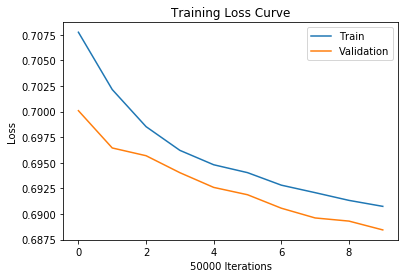

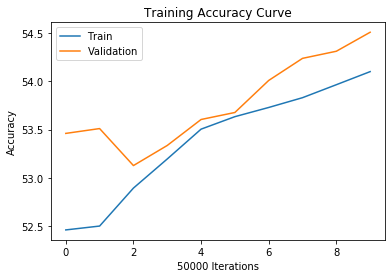

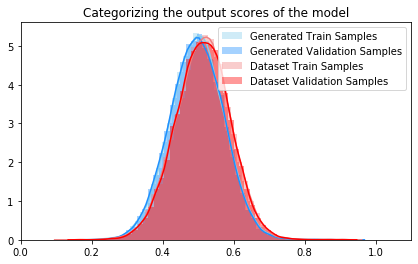

  5%|▌         | 50016/946094 [06:49<10:17:43, 24.18it/s]

Training Accuracy at epoch 0: 54.1
Validation Accuracy epoch 0: 54.508


 11%|█         | 99992/946094 [13:43<1:50:37, 127.47it/s]

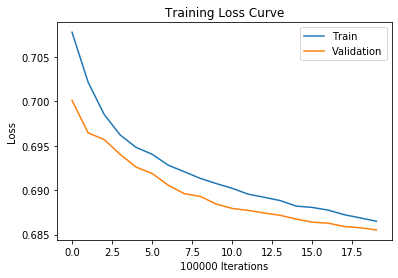

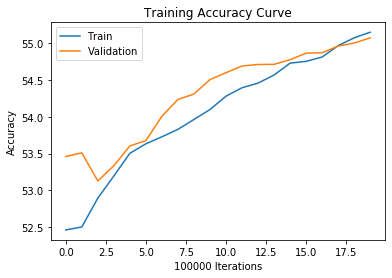

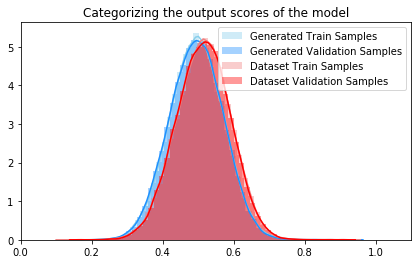

 11%|█         | 100026/946094 [13:45<10:26:24, 22.51it/s]

Training Accuracy at epoch 0: 55.153
Validation Accuracy epoch 0: 55.076


 16%|█▌        | 149994/946094 [20:31<1:59:33, 110.98it/s]

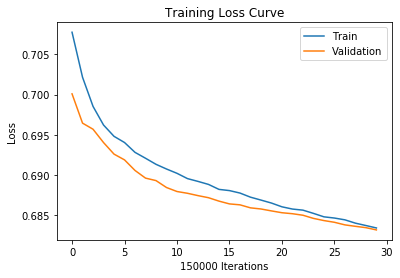

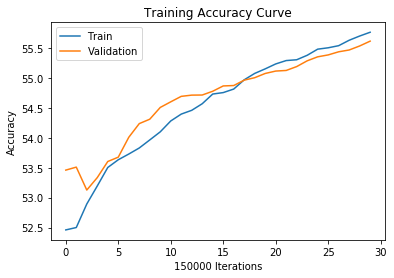

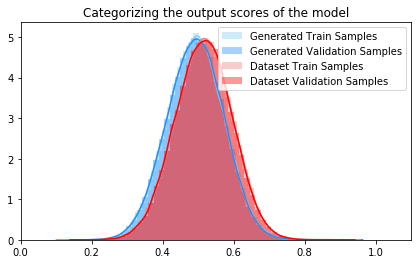

 16%|█▌        | 150016/946094 [20:35<15:12:45, 14.54it/s]

Training Accuracy at epoch 0: 55.76533333333333
Validation Accuracy epoch 0: 55.61666666666667


 21%|██        | 199982/946094 [27:33<1:54:00, 109.07it/s]

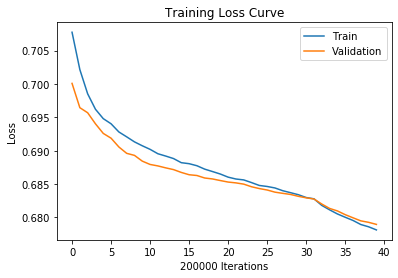

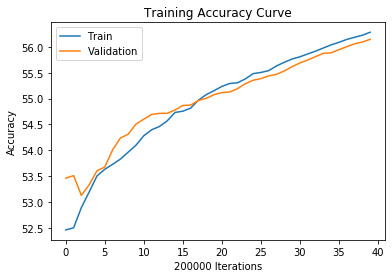

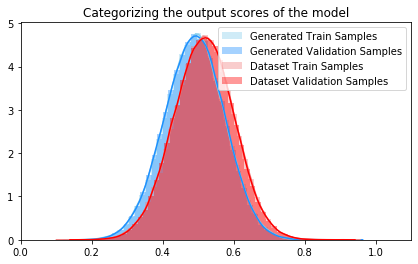

 21%|██        | 200018/946094 [27:36<9:24:55, 22.01it/s] 

Training Accuracy at epoch 0: 56.283
Validation Accuracy epoch 0: 56.146


 26%|██▋       | 249984/946094 [34:26<1:48:05, 107.33it/s]

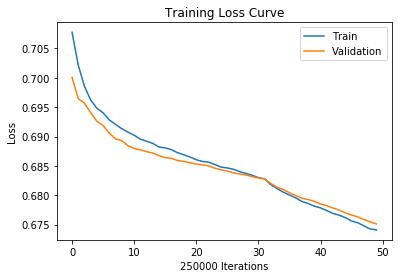

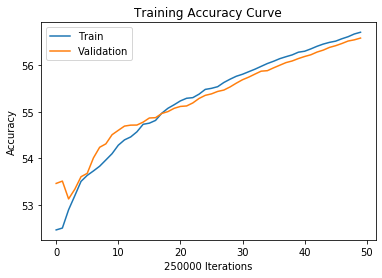

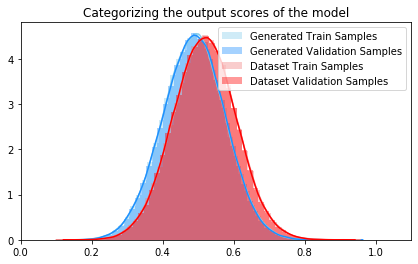

 26%|██▋       | 250016/946094 [34:30<11:56:46, 16.19it/s]

Training Accuracy at epoch 0: 56.712
Validation Accuracy epoch 0: 56.5868


 32%|███▏      | 299988/946094 [41:17<1:24:24, 127.58it/s]

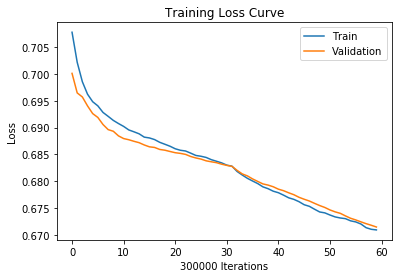

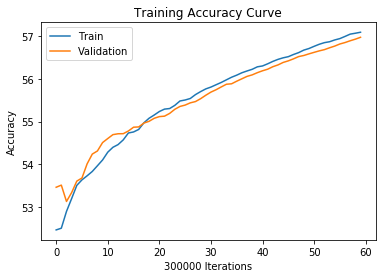

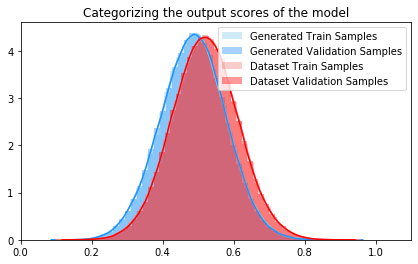

 32%|███▏      | 300023/946094 [41:20<10:36:55, 16.91it/s]

Training Accuracy at epoch 0: 57.093666666666664
Validation Accuracy epoch 0: 56.97533333333333


 37%|███▋      | 349995/946094 [48:10<1:28:07, 112.73it/s]

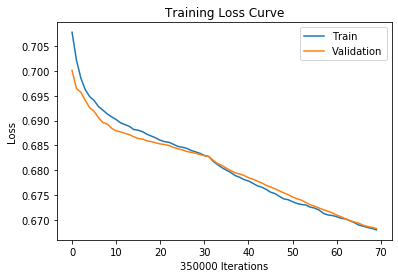

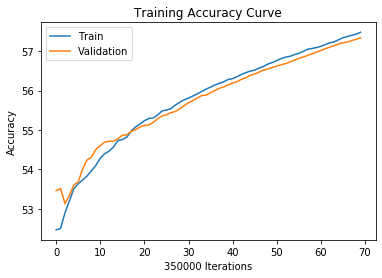

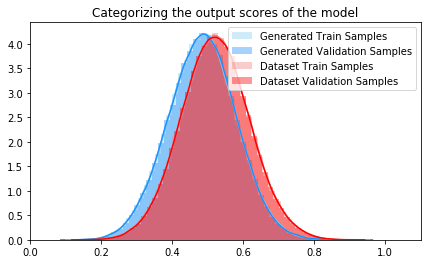

 37%|███▋      | 350018/946094 [48:15<14:46:14, 11.21it/s]

Training Accuracy at epoch 0: 57.482571428571426
Validation Accuracy epoch 0: 57.337714285714284


 42%|████▏     | 399992/946094 [55:05<1:14:32, 122.11it/s]

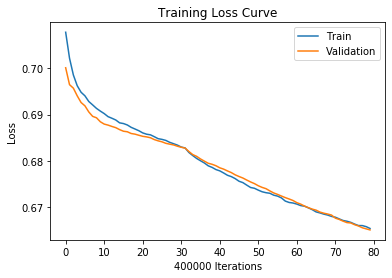

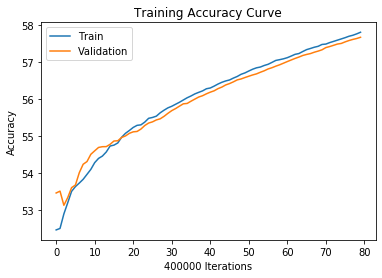

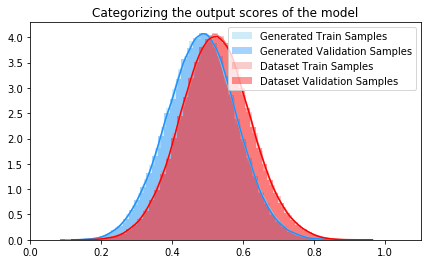

 42%|████▏     | 400027/946094 [55:10<11:47:17, 12.87it/s]

Training Accuracy at epoch 0: 57.81325
Validation Accuracy epoch 0: 57.6765


 48%|████▊     | 449987/946094 [1:02:05<1:19:28, 104.04it/s]

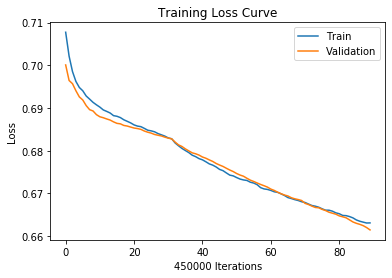

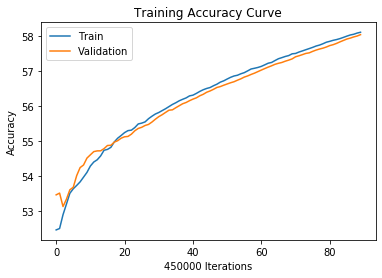

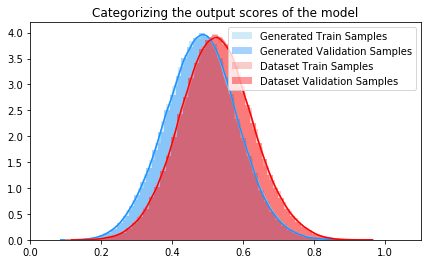

 48%|████▊     | 450016/946094 [1:02:10<11:28:44, 12.00it/s]

Training Accuracy at epoch 0: 58.09777777777778
Validation Accuracy epoch 0: 58.02911111111111


 53%|█████▎    | 499982/946094 [1:09:04<1:07:21, 110.39it/s]

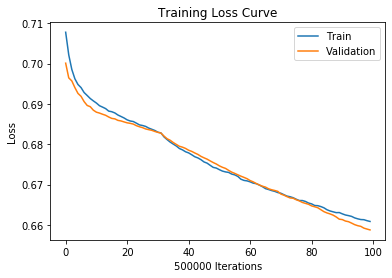

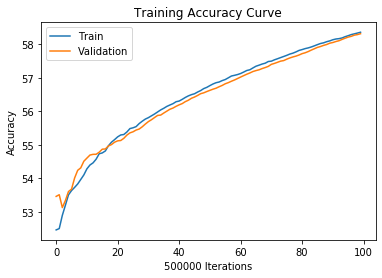

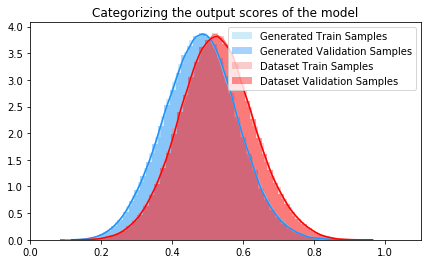

 53%|█████▎    | 500019/946094 [1:09:10<9:18:56, 13.30it/s] 

Training Accuracy at epoch 0: 58.3554
Validation Accuracy epoch 0: 58.3116


 58%|█████▊    | 549995/946094 [1:15:54<56:53, 116.04it/s]  

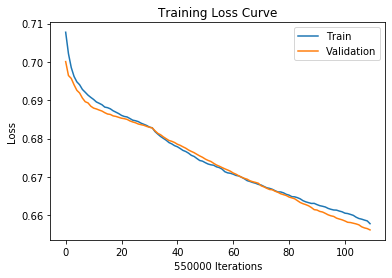

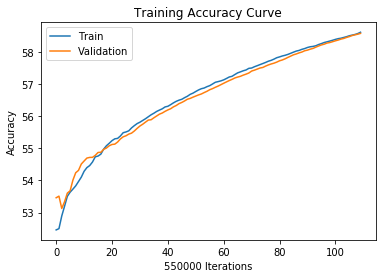

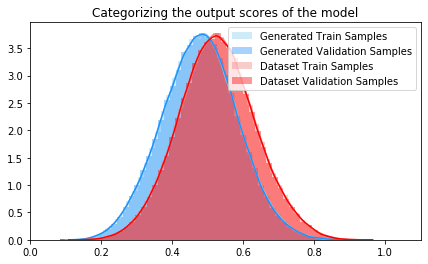

 58%|█████▊    | 550019/946094 [1:15:59<9:37:41, 11.43it/s] 

Training Accuracy at epoch 0: 58.60509090909091
Validation Accuracy epoch 0: 58.56963636363636


 63%|██████▎   | 599991/946094 [1:22:58<46:15, 124.69it/s]  

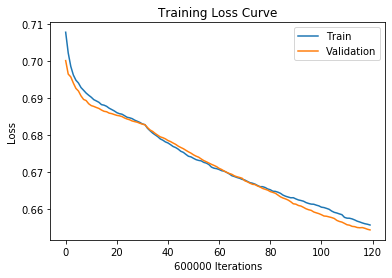

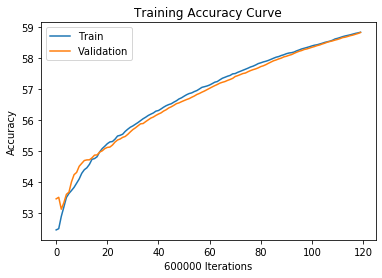

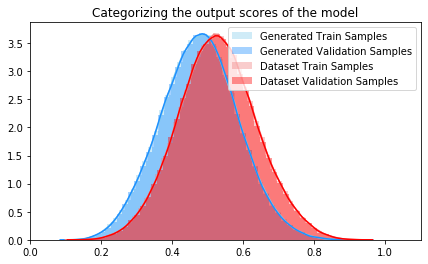

 63%|██████▎   | 600026/946094 [1:23:05<9:09:06, 10.50it/s] 

Training Accuracy at epoch 0: 58.82266666666667
Validation Accuracy epoch 0: 58.81483333333333


 69%|██████▊   | 649996/946094 [1:29:48<42:59, 114.81it/s] 

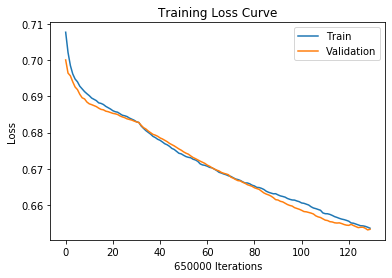

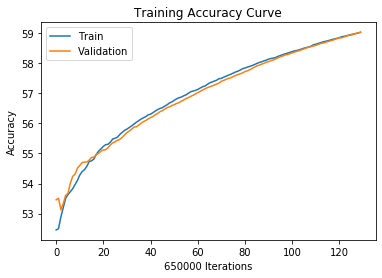

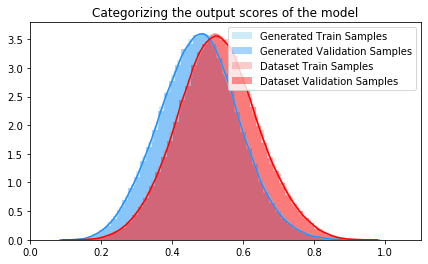

 69%|██████▊   | 650010/946094 [1:29:53<10:24:58,  7.90it/s]

Training Accuracy at epoch 0: 59.02569230769231
Validation Accuracy epoch 0: 59.02138461538461


 74%|███████▍  | 699988/946094 [1:36:51<33:22, 122.90it/s]  

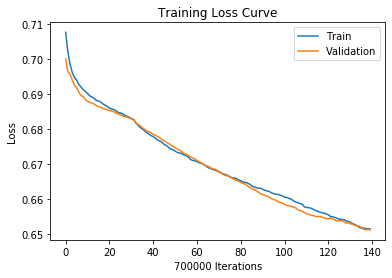

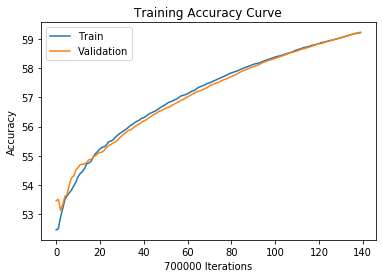

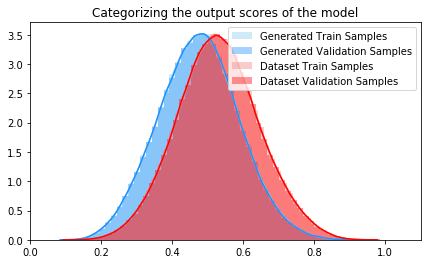

 74%|███████▍  | 700022/946094 [1:36:58<7:06:17,  9.62it/s]

Training Accuracy at epoch 0: 59.21928571428571
Validation Accuracy epoch 0: 59.233


 79%|███████▉  | 749994/946094 [1:43:48<28:28, 114.78it/s] 

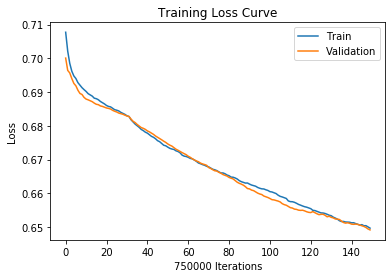

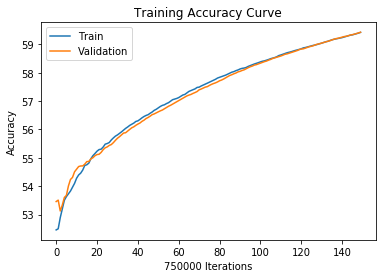

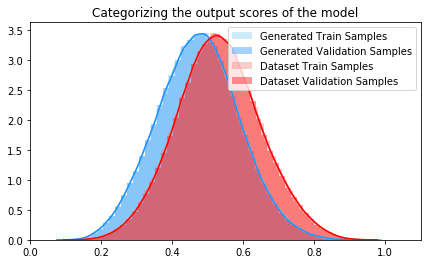

 79%|███████▉  | 750017/946094 [1:43:55<6:06:56,  8.91it/s]

Training Accuracy at epoch 0: 59.422133333333335
Validation Accuracy epoch 0: 59.42746666666667


 85%|████████▍ | 799994/946094 [1:50:49<19:14, 126.58it/s] 

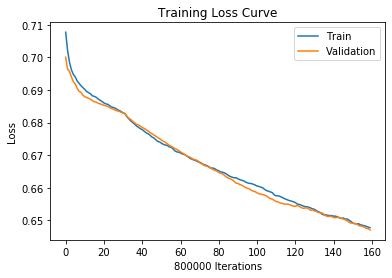

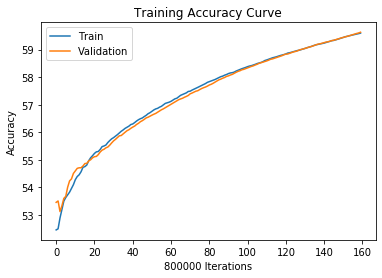

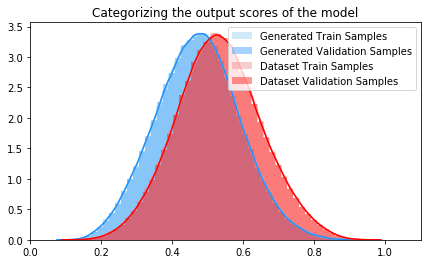

 85%|████████▍ | 800027/946094 [1:50:56<4:28:39,  9.06it/s]

Training Accuracy at epoch 0: 59.599625
Validation Accuracy epoch 0: 59.631375


 90%|████████▉ | 849984/946094 [1:57:54<11:22, 140.90it/s] 

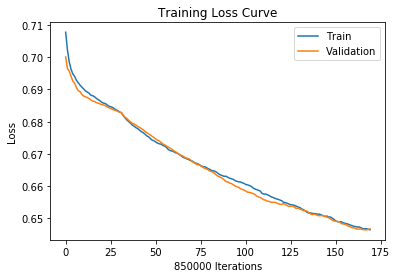

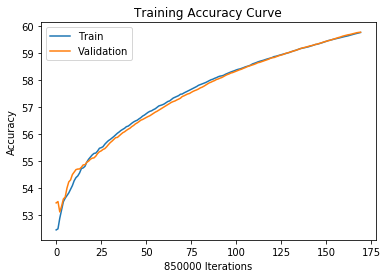

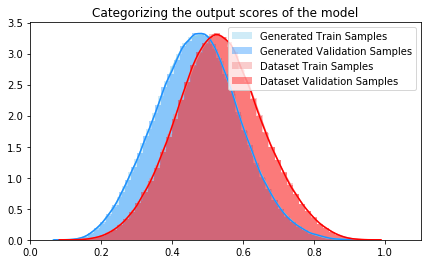

 90%|████████▉ | 850016/946094 [1:58:02<2:38:18, 10.11it/s]

Training Accuracy at epoch 0: 59.76964705882353
Validation Accuracy epoch 0: 59.778588235294116


 95%|█████████▌| 899991/946094 [2:05:00<06:05, 126.09it/s] 

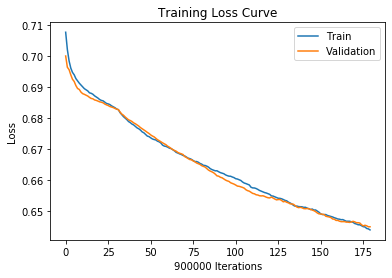

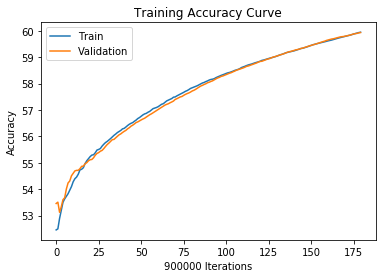

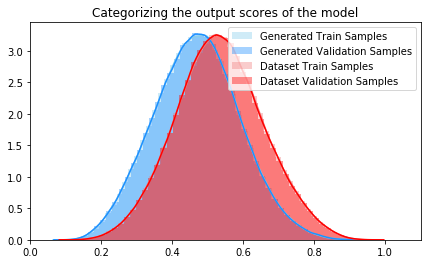

 95%|█████████▌| 900025/946094 [2:05:08<1:32:51,  8.27it/s]

Training Accuracy at epoch 0: 59.940777777777775
Validation Accuracy epoch 0: 59.93


  0%|          | 18/946094 [00:00<1:43:21, 152.57it/s]

Saving to:  model_checkpoints/binary/TranslateBatchNet/06182020.pth
Starting epoch: 1  with learning rate:  [0.01]


  0%|          | 3897/946094 [00:29<2:19:01, 112.95it/s]

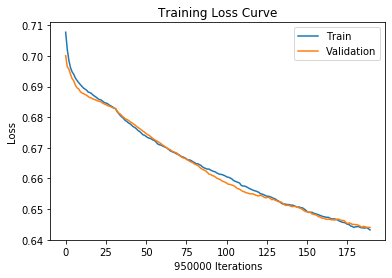

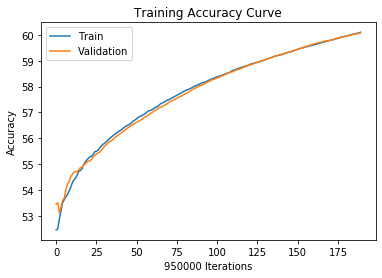

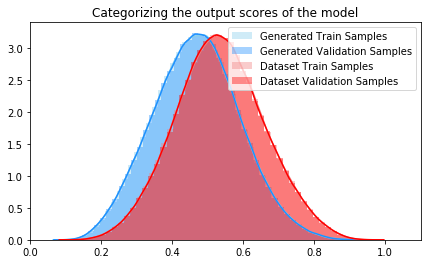

  0%|          | 3922/946094 [00:37<34:48:51,  7.52it/s]

Training Accuracy at epoch 1: 60.10284210526316
Validation Accuracy epoch 1: 60.07694736842105


  6%|▌         | 53898/946094 [07:26<1:57:51, 126.16it/s]

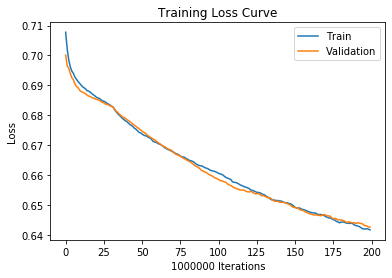

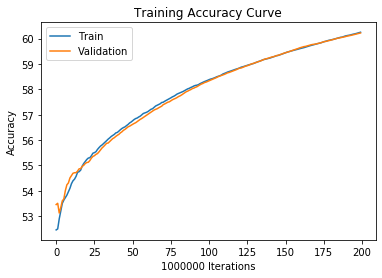

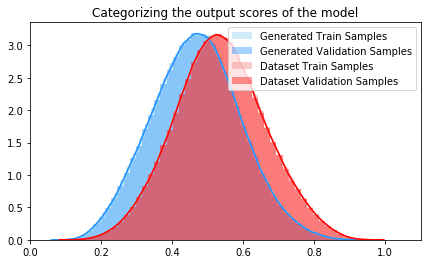

  6%|▌         | 53933/946094 [07:35<31:41:50,  7.82it/s]

Training Accuracy at epoch 1: 60.2511
Validation Accuracy epoch 1: 60.2224


 11%|█         | 103895/946094 [14:26<2:08:54, 108.89it/s]

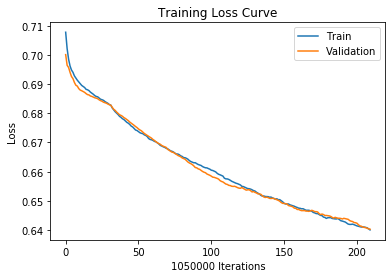

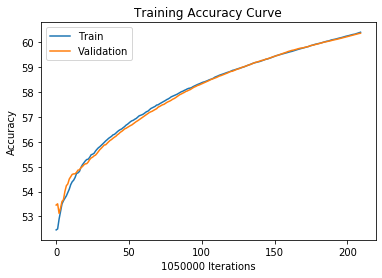

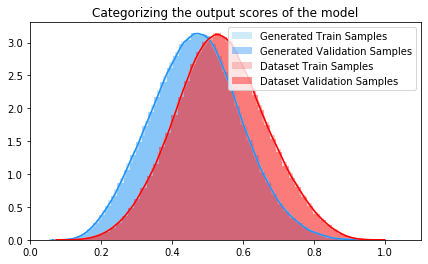

 11%|█         | 103922/946094 [14:34<32:53:13,  7.11it/s]

Training Accuracy at epoch 1: 60.411809523809524
Validation Accuracy epoch 1: 60.372


 16%|█▋        | 153905/946094 [21:27<1:46:27, 124.02it/s]

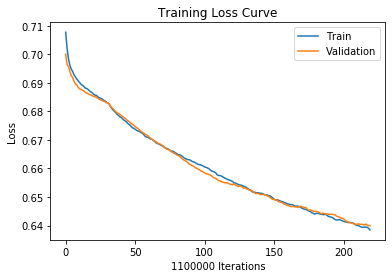

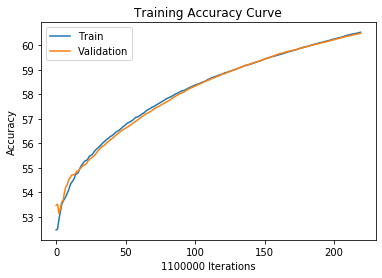

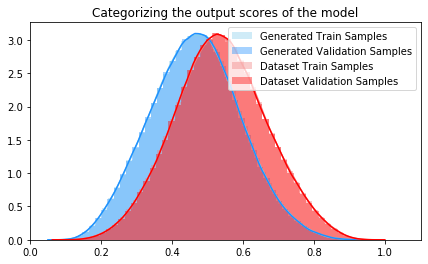

 16%|█▋        | 153920/946094 [21:37<42:20:31,  5.20it/s]

Training Accuracy at epoch 1: 60.54118181818182
Validation Accuracy epoch 1: 60.50154545454546


 22%|██▏       | 203899/946094 [28:16<1:46:47, 115.84it/s]

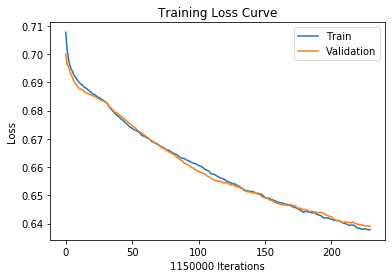

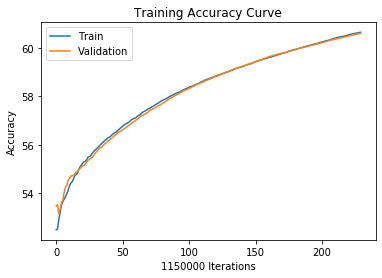

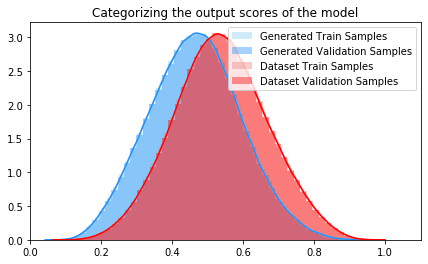

 22%|██▏       | 203923/946094 [28:25<29:04:37,  7.09it/s]

Training Accuracy at epoch 1: 60.66773913043478
Validation Accuracy epoch 1: 60.628173913043476


 27%|██▋       | 253902/946094 [35:19<1:28:39, 130.13it/s]

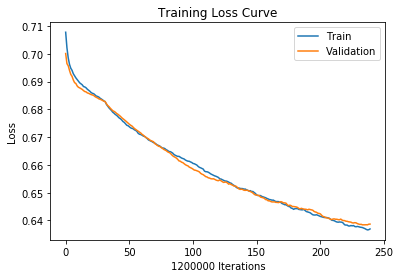

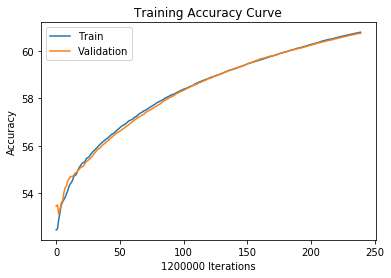

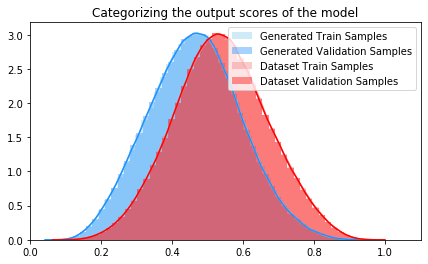

 27%|██▋       | 253936/946094 [35:29<27:51:34,  6.90it/s]

Training Accuracy at epoch 1: 60.782583333333335
Validation Accuracy epoch 1: 60.73775


 32%|███▏      | 303901/946094 [42:15<1:36:51, 110.51it/s]

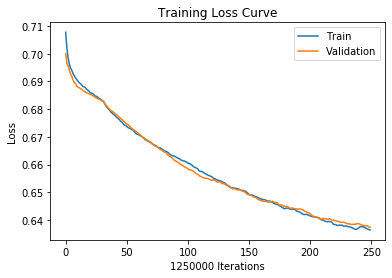

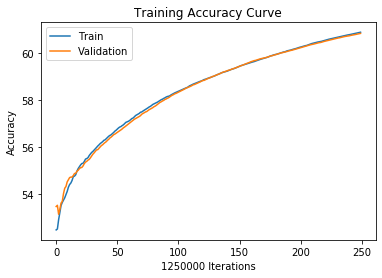

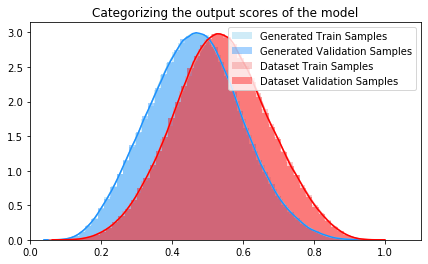

 32%|███▏      | 303923/946094 [42:24<28:47:08,  6.20it/s]

Training Accuracy at epoch 1: 60.89632
Validation Accuracy epoch 1: 60.84712


 37%|███▋      | 353887/946094 [49:23<1:31:03, 108.39it/s]

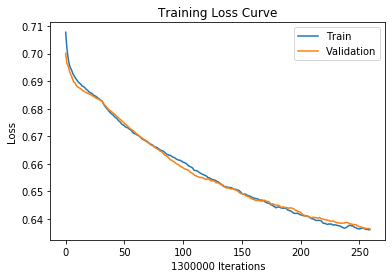

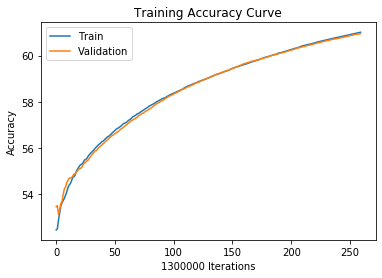

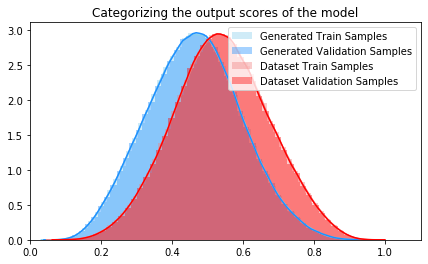

 37%|███▋      | 353925/946094 [49:34<20:44:08,  7.93it/s]

Training Accuracy at epoch 1: 61.01123076923077
Validation Accuracy epoch 1: 60.95607692307692


 43%|████▎     | 403892/946094 [56:24<1:28:29, 102.11it/s]

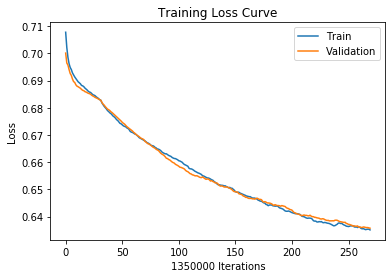

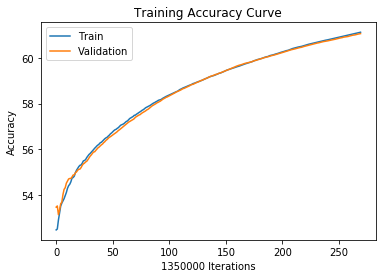

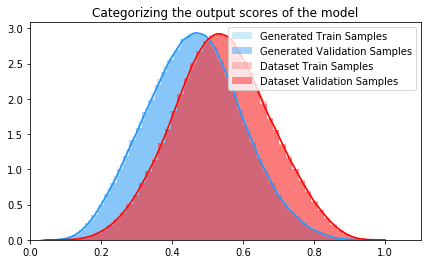

 43%|████▎     | 403922/946094 [56:34<24:47:53,  6.07it/s]

Training Accuracy at epoch 1: 61.12548148148148
Validation Accuracy epoch 1: 61.065629629629626


 48%|████▊     | 453898/946094 [1:03:22<1:06:08, 124.03it/s]

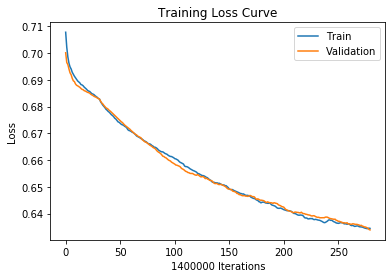

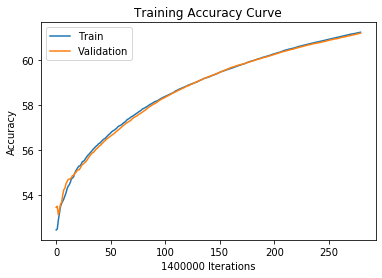

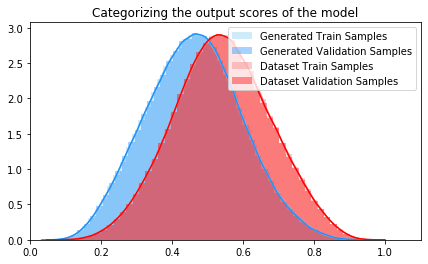

 48%|████▊     | 453932/946094 [1:03:34<24:22:49,  5.61it/s]

Training Accuracy at epoch 1: 61.21992857142857
Validation Accuracy epoch 1: 61.17921428571429


 53%|█████▎    | 503894/946094 [1:10:34<1:09:01, 106.76it/s]

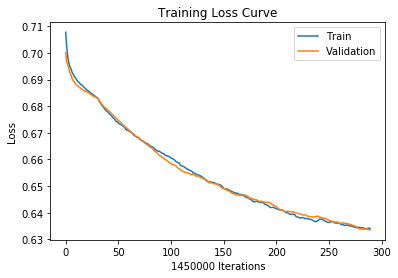

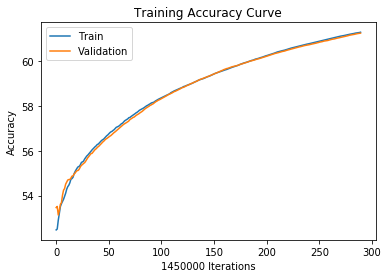

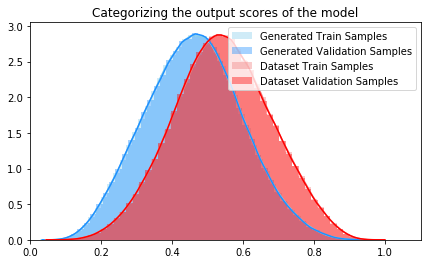

 53%|█████▎    | 503922/946094 [1:10:45<22:54:02,  5.36it/s]

Training Accuracy at epoch 1: 61.30862068965517
Validation Accuracy epoch 1: 61.26786206896552


 59%|█████▊    | 553895/946094 [1:17:37<52:57, 123.43it/s]  

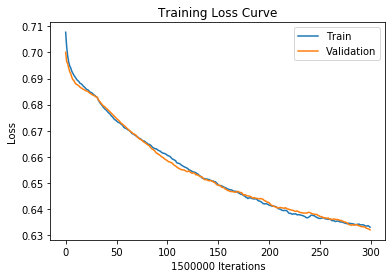

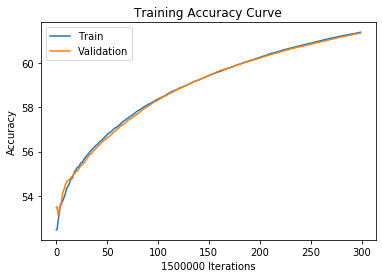

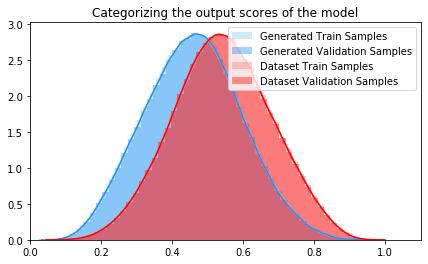

 59%|█████▊    | 553929/946094 [1:17:50<20:10:29,  5.40it/s]

Training Accuracy at epoch 1: 61.401066666666665
Validation Accuracy epoch 1: 61.36533333333333


 64%|██████▍   | 603894/946094 [1:24:32<51:18, 111.16it/s]  

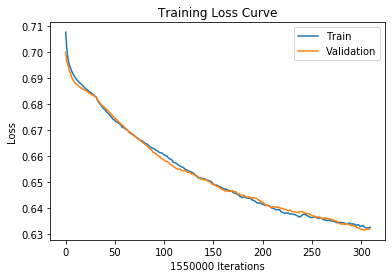

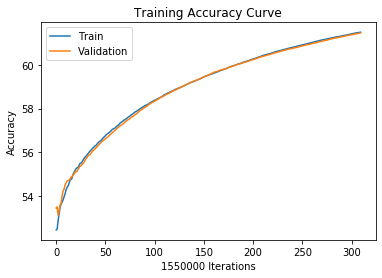

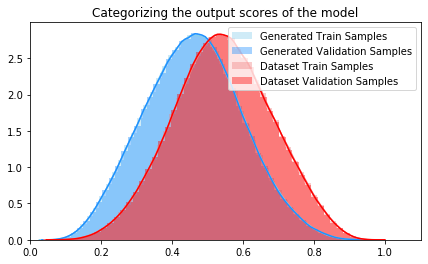

 64%|██████▍   | 603922/946094 [1:24:44<18:35:27,  5.11it/s]

Training Accuracy at epoch 1: 61.4841935483871
Validation Accuracy epoch 1: 61.45264516129032


 69%|██████▉   | 653894/946094 [1:31:35<38:00, 128.15it/s]  

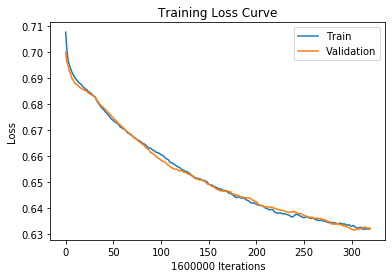

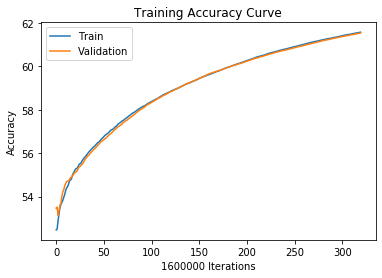

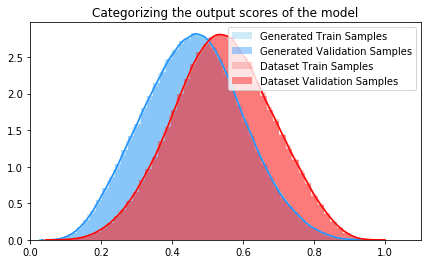

 69%|██████▉   | 653928/946094 [1:31:48<14:55:02,  5.44it/s]

Training Accuracy at epoch 1: 61.571375
Validation Accuracy epoch 1: 61.5381875


 74%|███████▍  | 703903/946094 [1:38:33<35:33, 113.51it/s]  

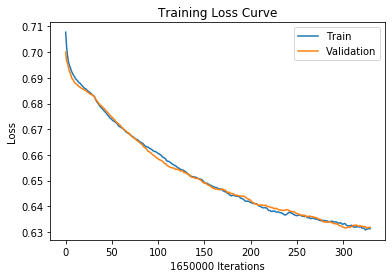

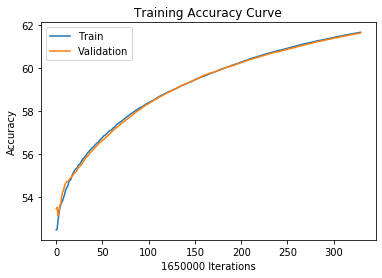

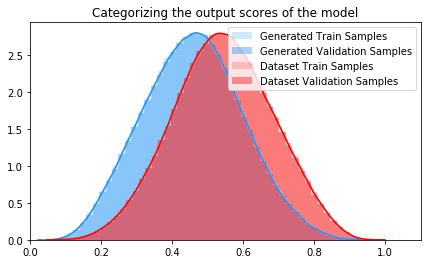

 74%|███████▍  | 703922/946094 [1:38:45<13:06:42,  5.13it/s]

Training Accuracy at epoch 1: 61.65260606060606
Validation Accuracy epoch 1: 61.619454545454545


 80%|███████▉  | 753887/946094 [1:45:35<27:54, 114.78it/s]  

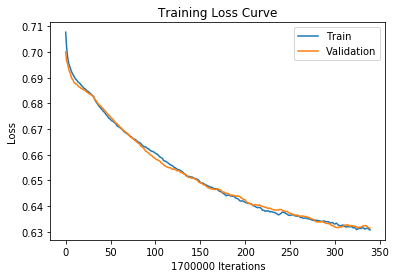

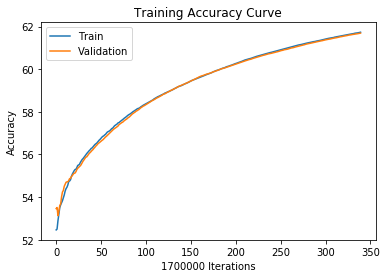

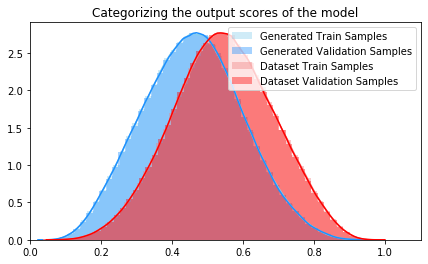

 80%|███████▉  | 753925/946094 [1:45:49<8:19:21,  6.41it/s] 

Training Accuracy at epoch 1: 61.73170588235294
Validation Accuracy epoch 1: 61.69023529411765


 85%|████████▍ | 803894/946094 [1:52:44<23:01, 102.90it/s] 

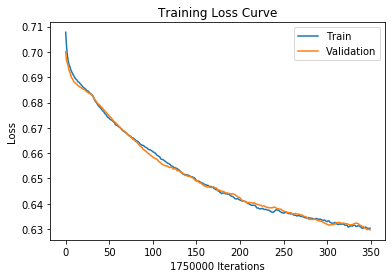

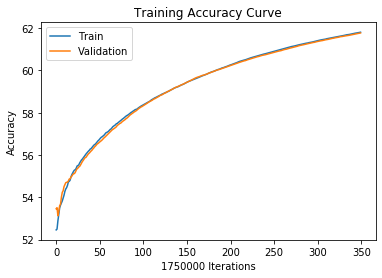

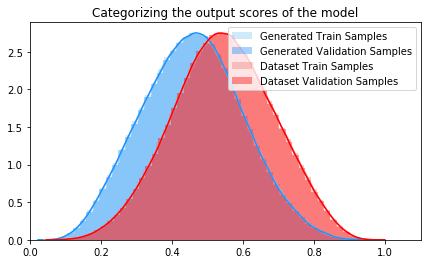

 85%|████████▍ | 803922/946094 [1:52:57<9:12:49,  4.29it/s] 

Training Accuracy at epoch 1: 61.8092
Validation Accuracy epoch 1: 61.775371428571425


 90%|█████████ | 853893/946094 [1:59:40<12:10, 126.23it/s] 

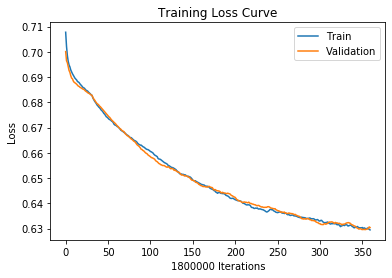

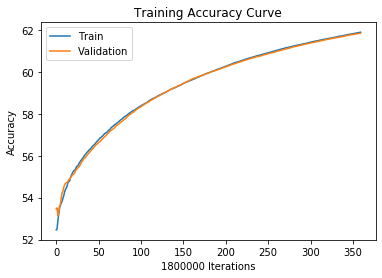

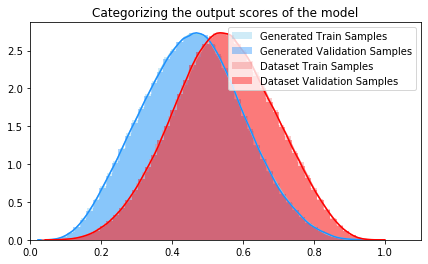

 90%|█████████ | 853927/946094 [1:59:54<5:10:19,  4.95it/s]

Training Accuracy at epoch 1: 61.88633333333333
Validation Accuracy epoch 1: 61.83716666666667


 96%|█████████▌| 903895/946094 [2:06:50<06:25, 109.59it/s] 

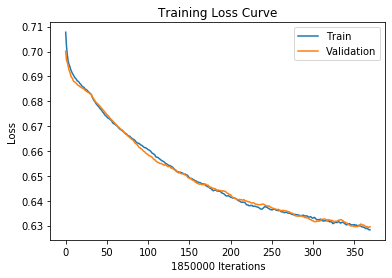

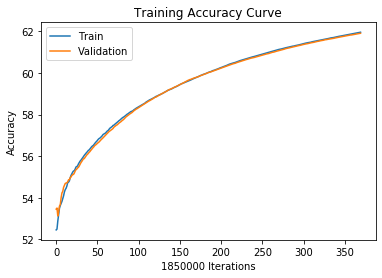

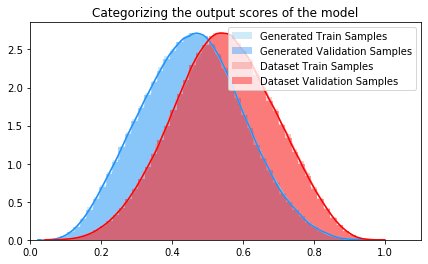

 96%|█████████▌| 903922/946094 [2:07:04<2:39:41,  4.40it/s]

Training Accuracy at epoch 1: 61.96010810810811
Validation Accuracy epoch 1: 61.911405405405404


  0%|          | 16/946094 [00:00<1:41:22, 155.55it/s]

Saving to:  model_checkpoints/binary/TranslateBatchNet/06182020.pth
Starting epoch: 2  with learning rate:  [0.008100000000000001]


  1%|          | 7803/946094 [01:02<2:02:31, 127.63it/s]

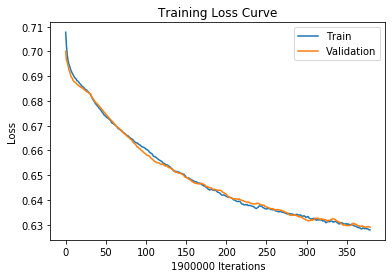

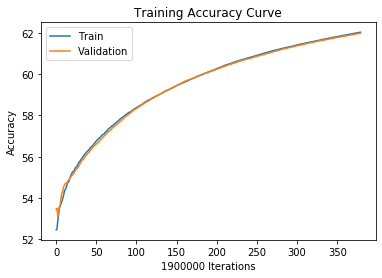

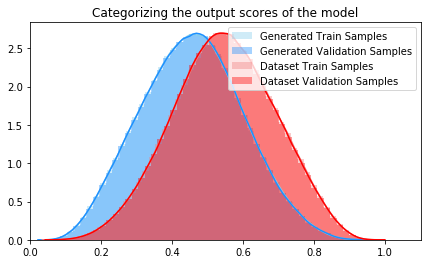

  1%|          | 7838/946094 [01:17<55:07:07,  4.73it/s]

Training Accuracy at epoch 2: 62.0268947368421
Validation Accuracy epoch 2: 61.982052631578945


  6%|▌         | 57797/946094 [08:06<2:14:52, 109.77it/s]

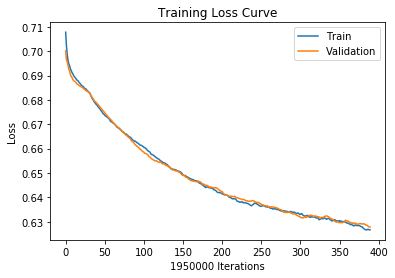

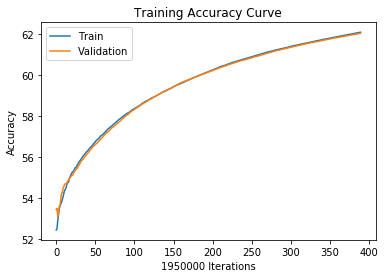

  6%|▌         | 57797/946094 [08:20<2:14:52, 109.77it/s]

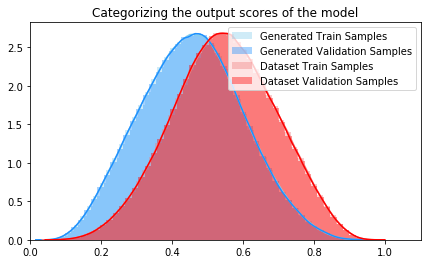

  6%|▌         | 57828/946094 [08:21<51:00:53,  4.84it/s]

Training Accuracy at epoch 2: 62.1025641025641
Validation Accuracy epoch 2: 62.04902564102564


 11%|█▏        | 107804/946094 [15:15<1:49:29, 127.60it/s]

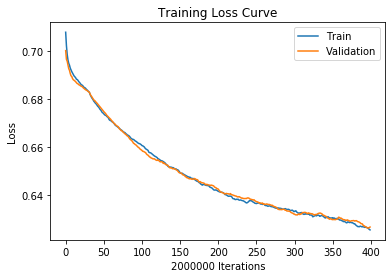

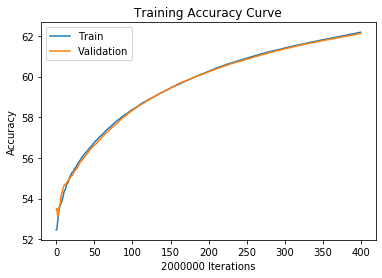

 11%|█▏        | 107804/946094 [15:30<1:49:29, 127.60it/s]

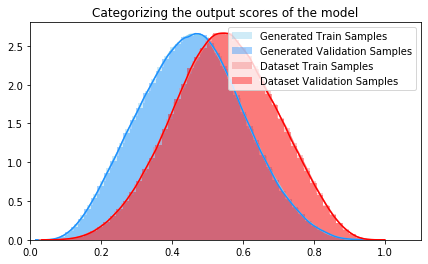

 11%|█▏        | 107831/946094 [15:30<94:38:30,  2.46it/s] 

Training Accuracy at epoch 2: 62.18425
Validation Accuracy epoch 2: 62.1188


 17%|█▋        | 157798/946094 [22:20<1:59:00, 110.40it/s]

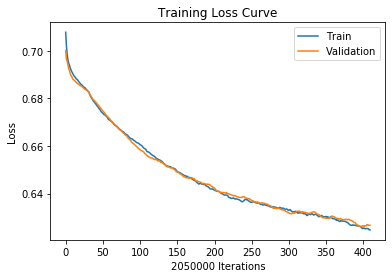

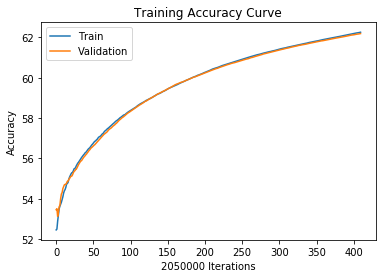

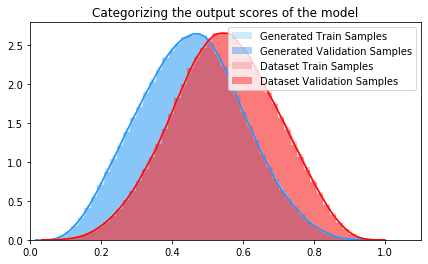

 17%|█▋        | 157828/946094 [22:35<50:37:59,  4.32it/s]

Training Accuracy at epoch 2: 62.25063414634146
Validation Accuracy epoch 2: 62.18468292682927


 22%|██▏       | 207793/946094 [29:31<1:52:23, 109.48it/s]

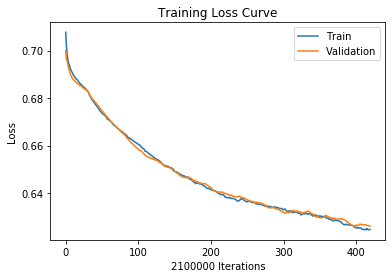

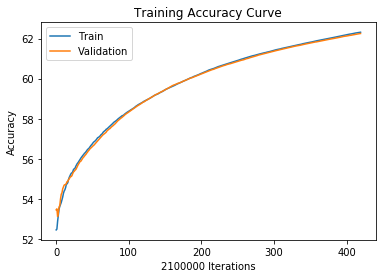

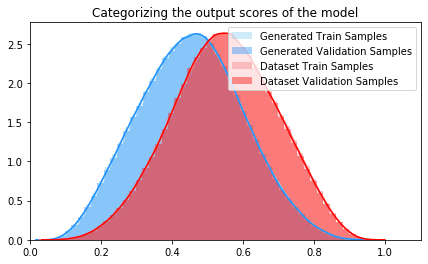

 22%|██▏       | 207831/946094 [29:47<37:37:21,  5.45it/s]

Training Accuracy at epoch 2: 62.31204761904762
Validation Accuracy epoch 2: 62.24971428571428


 27%|██▋       | 257797/946094 [36:42<1:48:56, 105.30it/s]

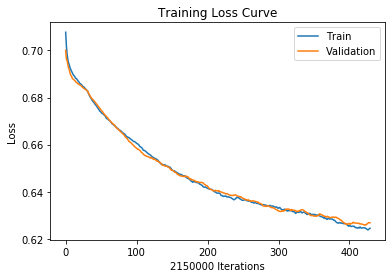

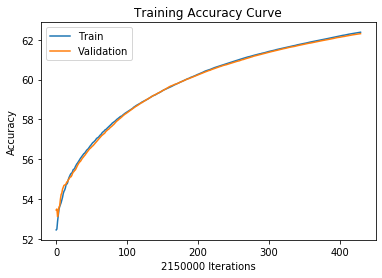

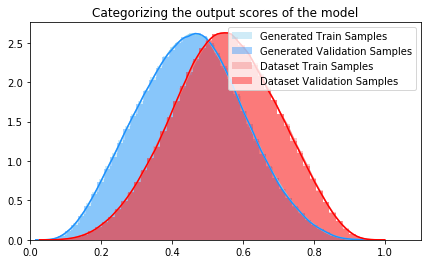

 27%|██▋       | 257828/946094 [36:58<43:05:58,  4.44it/s]

Training Accuracy at epoch 2: 62.37404651162791
Validation Accuracy epoch 2: 62.30288372093023


 33%|███▎      | 307811/946094 [43:40<1:23:00, 128.16it/s]

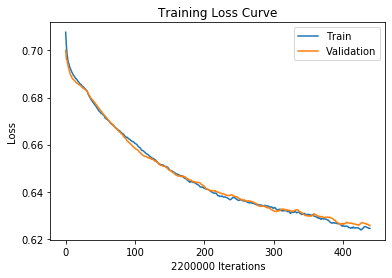

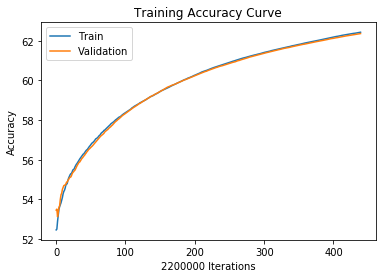

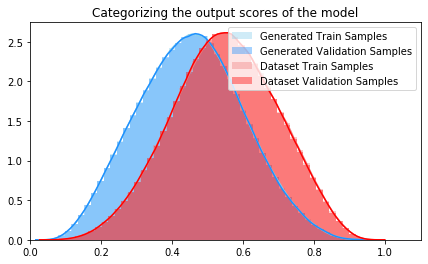

 33%|███▎      | 307826/946094 [43:57<60:04:26,  2.95it/s]

Training Accuracy at epoch 2: 62.43145454545454
Validation Accuracy epoch 2: 62.364909090909094


 38%|███▊      | 357801/946094 [50:49<1:26:12, 113.73it/s]

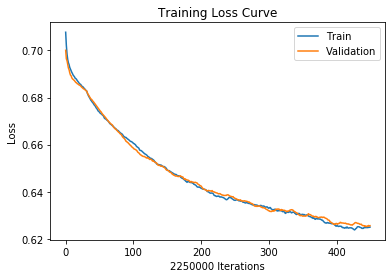

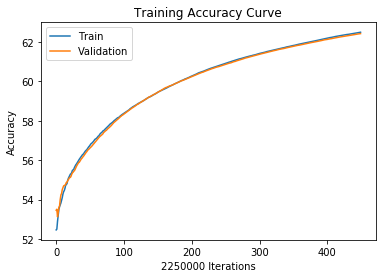

 38%|███▊      | 357801/946094 [51:00<1:26:12, 113.73it/s]

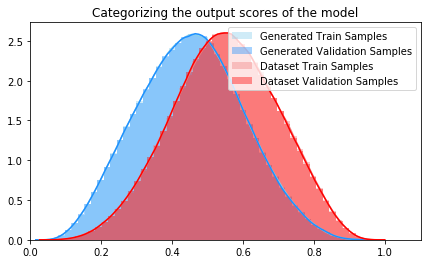

 38%|███▊      | 357828/946094 [51:06<53:28:17,  3.06it/s]

Training Accuracy at epoch 2: 62.48831111111111
Validation Accuracy epoch 2: 62.418844444444446


 43%|████▎     | 407799/946094 [58:03<1:14:27, 120.49it/s]

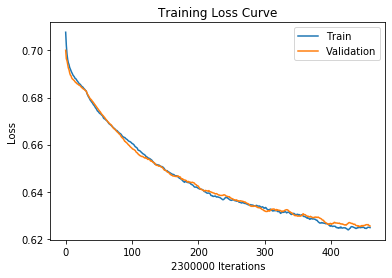

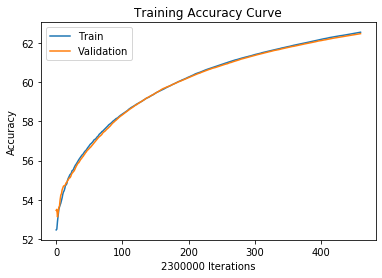

 43%|████▎     | 407799/946094 [58:20<1:14:27, 120.49it/s]

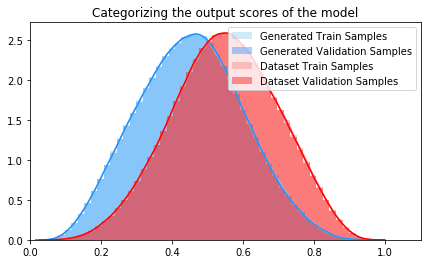

 43%|████▎     | 407831/946094 [58:21<42:42:17,  3.50it/s]

Training Accuracy at epoch 2: 62.54856521739131
Validation Accuracy epoch 2: 62.477260869565214


 48%|████▊     | 457802/946094 [1:05:10<1:11:51, 113.26it/s]

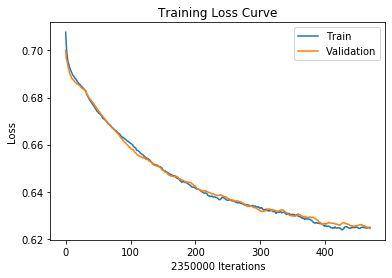

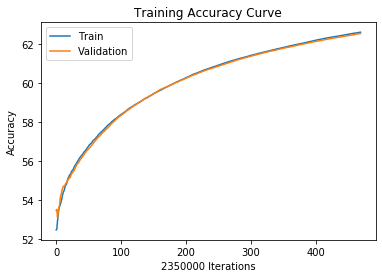

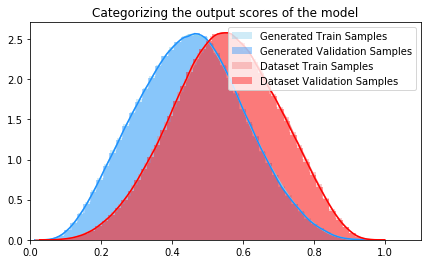

 48%|████▊     | 457828/946094 [1:05:28<35:36:28,  3.81it/s]

Training Accuracy at epoch 2: 62.5991914893617
Validation Accuracy epoch 2: 62.53655319148936


 54%|█████▎    | 507794/946094 [1:12:27<1:07:38, 108.00it/s]

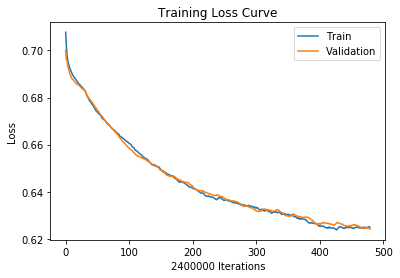

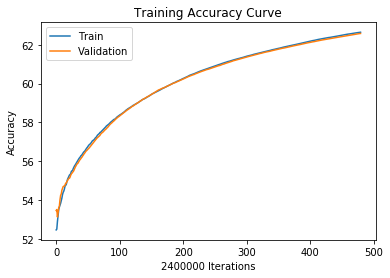

 54%|█████▎    | 507794/946094 [1:12:40<1:07:38, 108.00it/s]

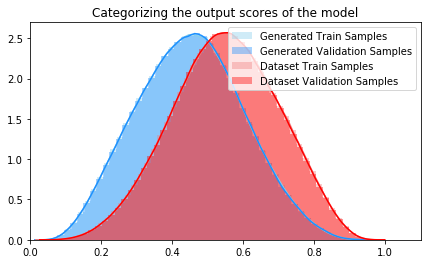

 54%|█████▎    | 507831/946094 [1:12:46<26:40:18,  4.56it/s]

Training Accuracy at epoch 2: 62.646541666666664
Validation Accuracy epoch 2: 62.58391666666667


 59%|█████▉    | 557799/946094 [1:19:45<58:22, 110.87it/s]  

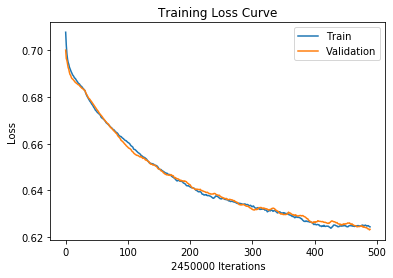

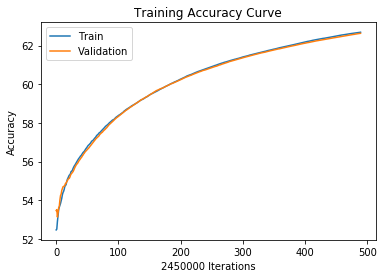

 59%|█████▉    | 557799/946094 [1:20:00<58:22, 110.87it/s]

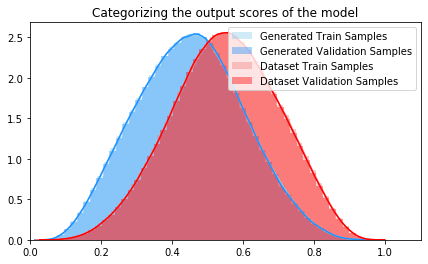

 59%|█████▉    | 557828/946094 [1:20:03<31:53:55,  3.38it/s]

Training Accuracy at epoch 2: 62.69155102040816
Validation Accuracy epoch 2: 62.636326530612244


 64%|██████▍   | 607807/946094 [1:26:58<43:38, 129.19it/s]  

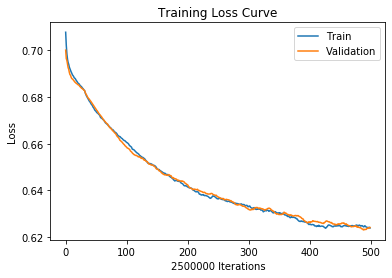

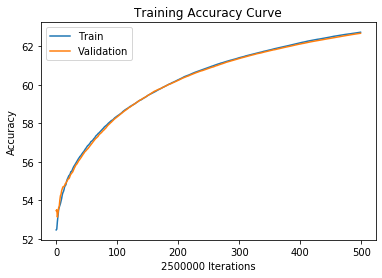

 64%|██████▍   | 607807/946094 [1:27:10<43:38, 129.19it/s]

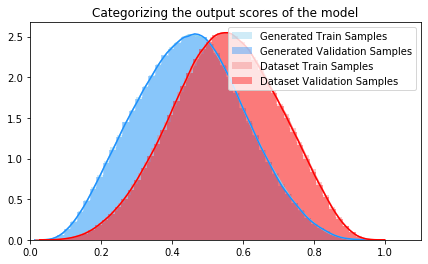

 64%|██████▍   | 607831/946094 [1:27:17<74:38:04,  1.26it/s] 

Training Accuracy at epoch 2: 62.73808
Validation Accuracy epoch 2: 62.68468


 70%|██████▉   | 657798/946094 [1:34:11<43:11, 111.26it/s]  

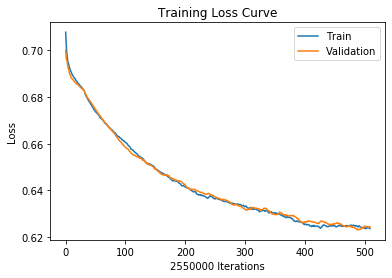

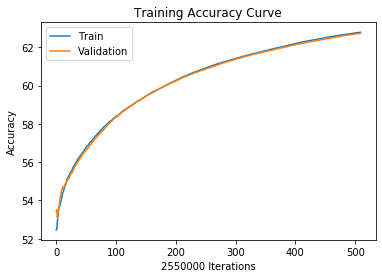

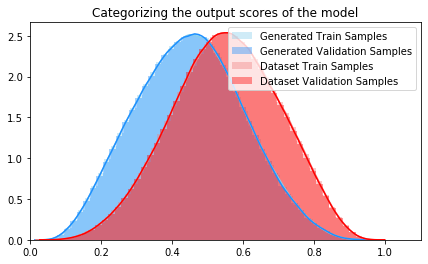

 70%|██████▉   | 657828/946094 [1:34:29<23:09:44,  3.46it/s]

Training Accuracy at epoch 2: 62.78074509803922
Validation Accuracy epoch 2: 62.730980392156866


 75%|███████▍  | 707803/946094 [1:41:19<31:05, 127.71it/s]  

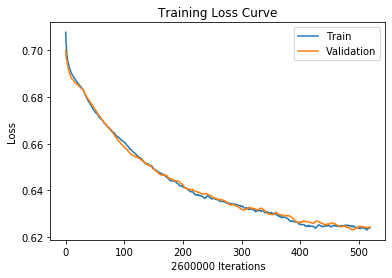

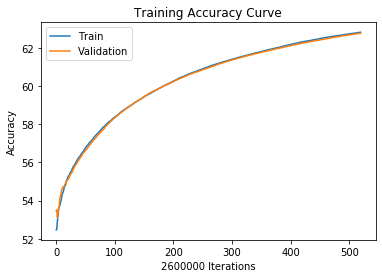

 75%|███████▍  | 707803/946094 [1:41:30<31:05, 127.71it/s]

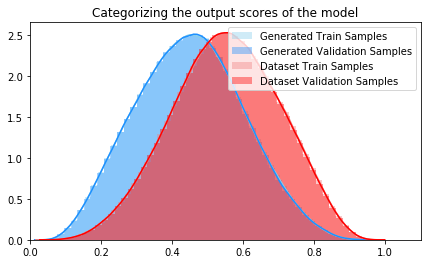

 75%|███████▍  | 707831/946094 [1:41:39<30:15:35,  2.19it/s]

Training Accuracy at epoch 2: 62.82673076923077
Validation Accuracy epoch 2: 62.77584615384615


 80%|████████  | 757801/946094 [1:48:21<27:41, 113.33it/s]  

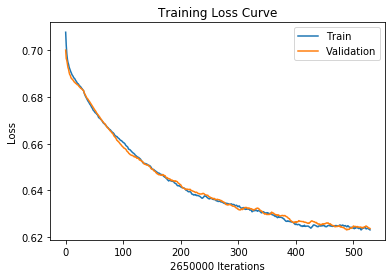

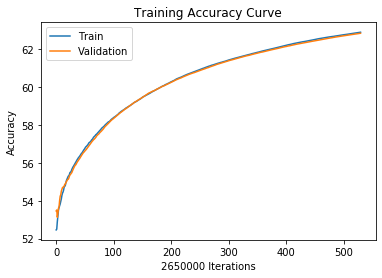

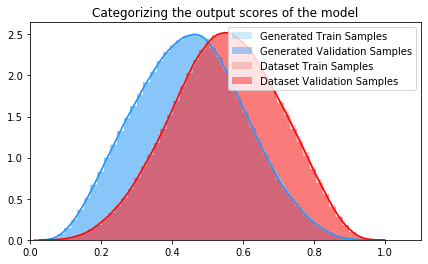

 80%|████████  | 757828/946094 [1:48:41<16:27:29,  3.18it/s]

Training Accuracy at epoch 2: 62.87396226415094
Validation Accuracy epoch 2: 62.82196226415094


 85%|████████▌ | 807804/946094 [1:55:36<18:36, 123.89it/s]  

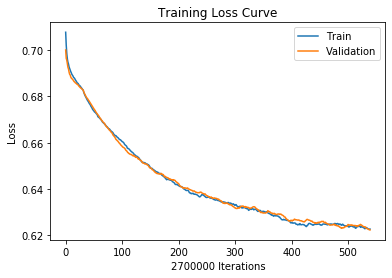

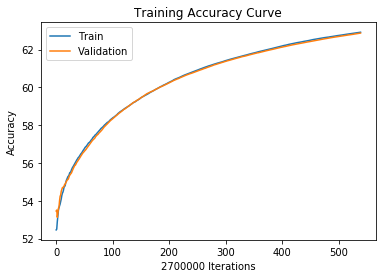

 85%|████████▌ | 807804/946094 [1:55:50<18:36, 123.89it/s]

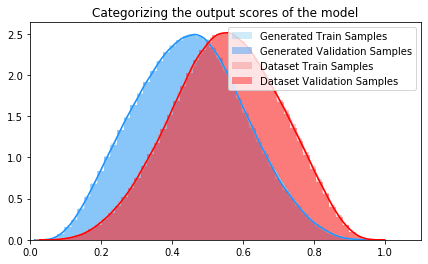

 85%|████████▌ | 807835/946094 [1:55:56<20:26:42,  1.88it/s]

Training Accuracy at epoch 2: 62.91385185185185
Validation Accuracy epoch 2: 62.869703703703706


 87%|████████▋ | 827738/946094 [1:58:37<15:42, 125.53it/s]  

In [ ]:
model = TranslateBatchNet()
model_name = model.name
model_id = "06182020"
model.to(device)
checkpoint = None
save_path = 'model_checkpoints/binary/%s/%s.pth' % (model_name, model_id)
single_alphabet = False
NUM_EPOCHS = 10
BATCH_SIZE = 32
cdf=False
gamma = 1e-2
classifier(model, binary_train, binary_val, gamma, model_id, NUM_EPOCHS, BATCH_SIZE, single_alphabet, checkpoint, save_path, cdf=cdf)